# 프로젝트. 폐렴아 기다려라 

- 의료 영상 종류
    - xray
    - ct
    - mri

- 의료 영상 단면
    + Sagittal plane : 시상면. 사람을 왼쪽과 오른쪽을 나누는 면.

    + Coronal plane : 관상면. 인체를 앞 뒤로 나누는 면.

    + Transverse plane : 횡단면(수평면). 인체를 상하로 나누는 면.
    
    
 

## data download
- kaggle  중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X 선 영상
- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## library import

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지


## set

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/AIFFEL_LSG/utill')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)


/home/aiffel0042/aiffel/AIFFEL_LSG/utill


## data load`

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
## train, validatoin set spilt

In [5]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))
# 붙이고 확장.

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2) # 다시 나눔.....

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
# 이미지 중 정상 이미지와 페렴 이미지  개수 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

## 데이터는 불귤현ㅇ, 차후 조정 예정.


Normal images count in training set: 1091
Pneumonia images count in training set: 3094


In [7]:
## tf.data. instace
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
## dat aset count
리

Training images count: 4185
Validating images count: 1047


In [9]:
## label name
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [10]:


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [11]:
##사이즈 조절
## float 형변환


def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

## data set make

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# label 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [14]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼 유지하고 해당 버퍼에서 무작위 료 균일하기 다음 ㅇ요소 선택

    ds = ds.repeat() #  epoch 진행 시 여러번 데이터셋을 사용할 수 있게 해줌.

    ds = ds.batch(BATCH_SIZE) # batch size 만큼 batch 나눔.

    ds = ds.prefetch(buffer_size=AUTOTUNE) # 첫번째 데이터를 GPU에서 학습하는 동안 두번째 데이터를 cpu에서 준비시킴.

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [16]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

## data 시각화

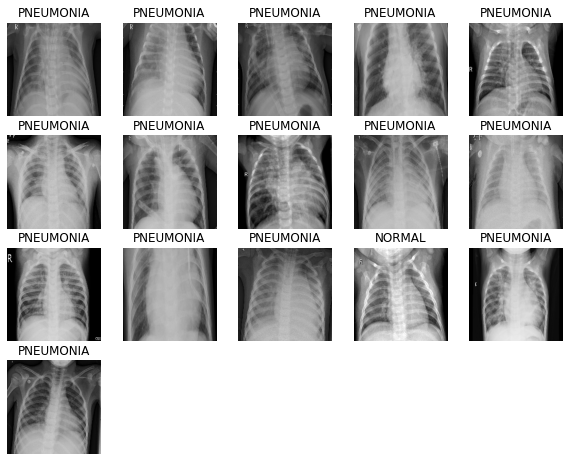

In [17]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
train_ds
val_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

## cnn model

### conv block 함수`ㅡ

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [20]:
### dense block 함수
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
### model build fn
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## data imbalance 처리
- 데이터중 페렴 데이터가 더 많음.

- weight balancing : training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은    
'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은    
'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정   

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.92
Weight for class 1: 0.68


## model train

In [23]:
## gpu 설정
## 이미지 라벨이 2개 이기에 loss 를 binary_cross_entropy 사용
# 성과 측정 metrics으로 'accuracy', 'precision', 'recall'
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 24s 93ms/step - loss: 0.4019 - accuracy: 0.8070 - precision: 0.9478 - recall: 0.7819 - val_loss: 0.6265 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 90ms/step - loss: 0.2508 - accuracy: 0.9028 - precision: 0.9705 - recall: 0.8957 - val_loss: 1.0965 - val_accuracy: 0.7538 - val_precision: 0.7538 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 90ms/step - loss: 0.1977 - accuracy: 0.9260 - precision: 0.9754 - recall: 0.9233 - val_loss: 0.3890 - val_accuracy: 0.8087 - val_precision: 0.7971 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 23s 90ms/step - loss: 0.1670 - accuracy: 0.9385 - precision: 0.9819 - recall: 0.9339 - val_loss: 0.3969 - val_accuracy: 0.8087 - val_precision: 0.7978 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 23s 90ms/step - loss: 0.1707 - accuracy: 0

# 결과 확인

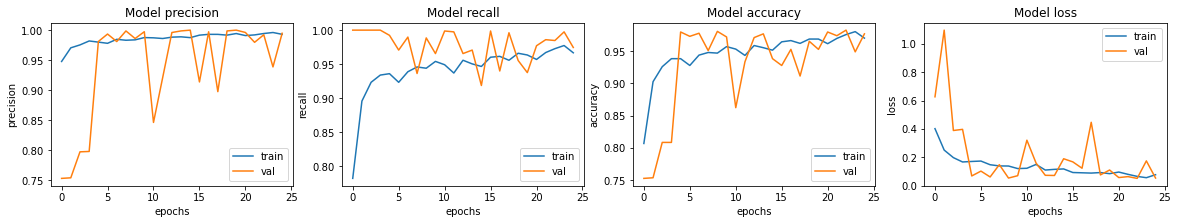

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
##평가 ##########

In [26]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 0.9575 - accuracy: 0.8237 - precision: 0.7881 - recall: 0.9821
